## Deep Image Classifier

In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2
import imghdr

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
data_dir='data2'

In [8]:
image_exts=['jpeg', 'jpg', 'png', 'bmp']

In [10]:
img=cv2.imread(os.path.join('data2', 'happy', '8cxKy5g9i.jpg'))

In [12]:
img

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [15]:
img.shape

(1733, 2600, 3)

In [16]:
import matplotlib.pyplot as plt

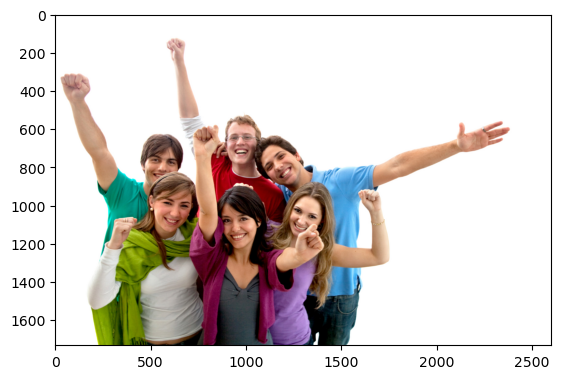

In [18]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [19]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [53]:
#Load Data

data=tf.keras.utils.image_dataset_from_directory('data2')

Found 305 files belonging to 2 classes.


In [21]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [31]:
data_iterator=data.as_numpy_iterator()

In [32]:
batch=data_iterator.next()

In [33]:
batch[0].shape

(32, 256, 256, 3)

In [34]:
batch[1]

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0])

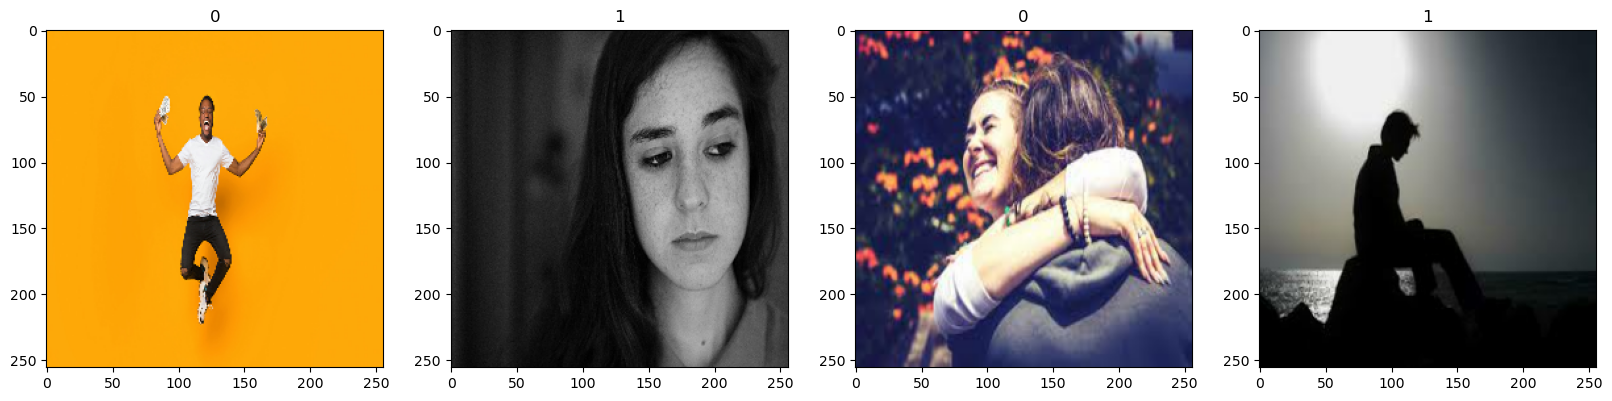

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [54]:
#Scale data

data=data.map(lambda x,y: (x/255, y))

In [55]:
scaled_iterator=data.as_numpy_iterator()

In [56]:
batch=scaled_iterator.next()

In [57]:
batch[0].max()

1.0

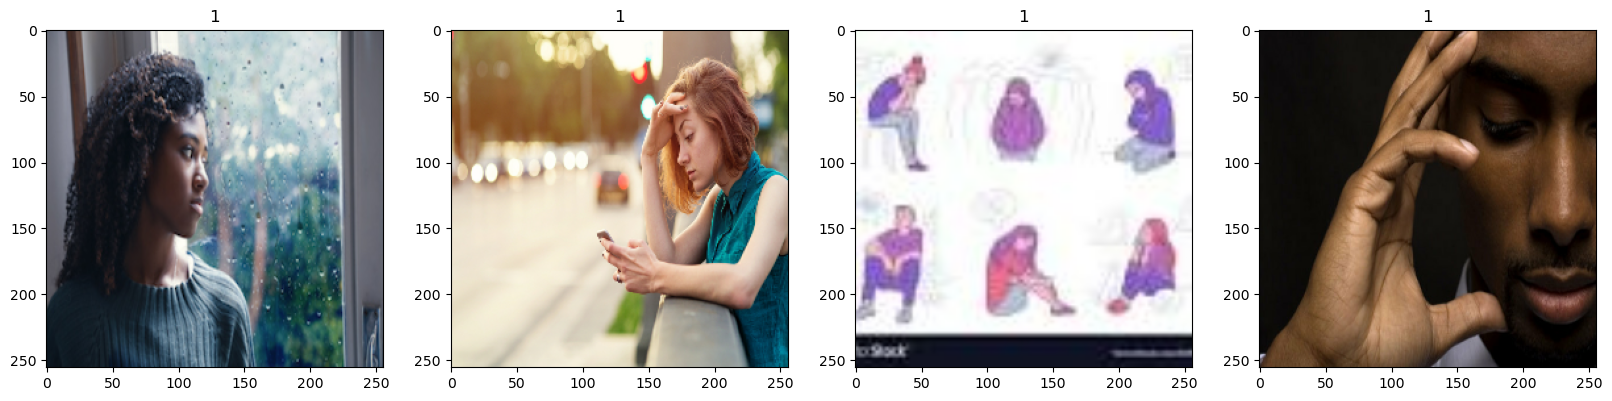

In [58]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [59]:
#Data split
len(data)

10

In [60]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [63]:
train_size+val_size+test_size

10

In [64]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [68]:
len(test)

1

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout      

In [71]:
model=Sequential()

In [72]:

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [73]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [77]:
logdir='logs'

In [78]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [79]:
hist=model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 13s 267ms/step - loss: 0.9006 - accuracy: 0.5402 - val_loss: 0.6615 - val_accuracy: 0.6719
Epoch 2/20
7/7 [==============================] - 3s 295ms/step - loss: 0.6689 - accuracy: 0.6250 - val_loss: 0.6233 - val_accuracy: 0.6875
Epoch 3/20
7/7 [==============================] - 3s 290ms/step - loss: 0.6085 - accuracy: 0.6161 - val_loss: 0.5016 - val_accuracy: 0.8594
Epoch 4/20
7/7 [==============================] - 3s 302ms/step - loss: 0.5255 - accuracy: 0.7946 - val_loss: 0.5079 - val_accuracy: 0.7344
Epoch 5/20
7/7 [==============================] - 3s 293ms/step - loss: 0.4520 - accuracy: 0.8080 - val_loss: 0.3609 - val_accuracy: 0.8594
Epoch 6/20
7/7 [==============================] - 3s 297ms/step - loss: 0.4295 - accuracy: 0.7991 - val_loss: 0.4176 - val_accuracy: 0.8125
Epoch 7/20
7/7 [==============================] - 3s 296ms/step - loss: 0.3429 - accuracy: 0.8571 - val_loss: 0.2560 - val_accuracy: 0.9062
Epoch 8/20
7/7 [===

In [81]:
hist.history

{'loss': [0.9006310701370239,
  0.6689351201057434,
  0.6084708571434021,
  0.5254576802253723,
  0.4519960582256317,
  0.4295043349266052,
  0.34286388754844666,
  0.27707940340042114,
  0.20477846264839172,
  0.1562674343585968,
  0.12086200714111328,
  0.1113400012254715,
  0.09415648877620697,
  0.08338002860546112,
  0.04406358674168587,
  0.06793413311243057,
  0.09437122195959091,
  0.09790694713592529,
  0.04631510004401207,
  0.017085673287510872],
 'accuracy': [0.5401785969734192,
  0.625,
  0.6160714030265808,
  0.7946428656578064,
  0.8080357313156128,
  0.7991071343421936,
  0.8571428656578064,
  0.9196428656578064,
  0.9419642686843872,
  0.9508928656578064,
  0.9598214030265808,
  0.9642857313156128,
  0.9776785969734192,
  0.9776785969734192,
  0.9910714030265808,
  0.96875,
  0.9642857313156128,
  0.9598214030265808,
  1.0,
  1.0],
 'val_loss': [0.6614847183227539,
  0.6232702732086182,
  0.5015525817871094,
  0.5079027414321899,
  0.36087730526924133,
  0.417585343122

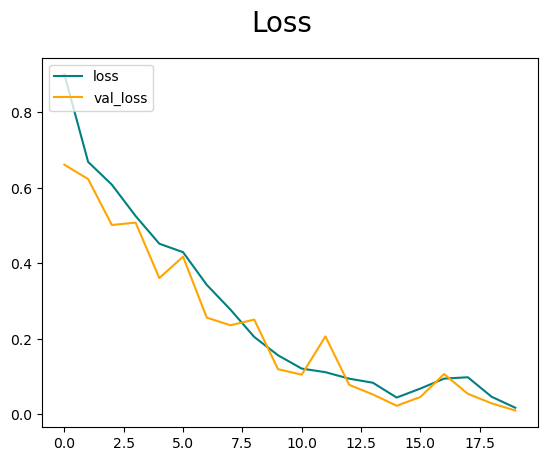

In [80]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


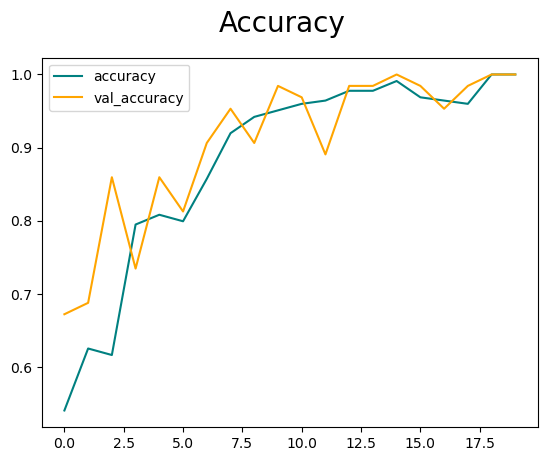

In [82]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [84]:
#Evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [85]:
pre=Precision()
re=Recall()
ac=BinaryAccuracy()

In [87]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    ac.update_state(y, yhat)

1/1 [==============================] - 0s 31ms/step


In [89]:
print(pre.result(), re.result(), ac.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


## Test

In [93]:
import cv2
import matplotlib.pyplot as plt

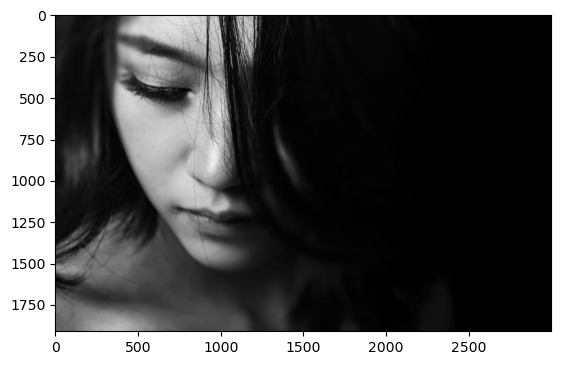

In [103]:
img2=cv2.imread('image3.jpg')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

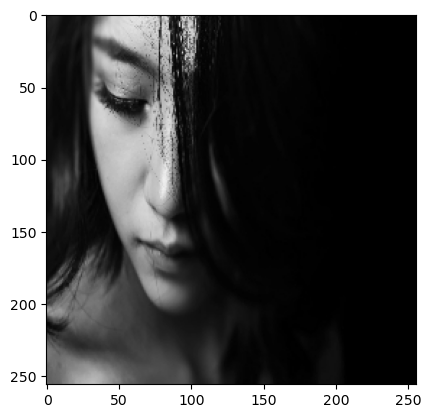

In [104]:
resize = tf.image.resize(img2, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [105]:
resize

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[ 30.642578,  30.642578,  30.642578],
        [ 27.      ,  27.      ,  27.      ],
        [ 29.      ,  29.      ,  29.      ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       [[ 30.      ,  30.      ,  30.      ],
        [ 29.      ,  29.      ,  29.      ],
        [ 30.      ,  30.      ,  30.      ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       [[ 30.642578,  30.642578,  30.642578],
        [ 30.      ,  30.      ,  30.      ],
        [ 31.      ,  31.      ,  31.      ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       ...,

       [[ 98.30297 ,  98.30297 ,  98.30297 ],
        [ 99.

In [106]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 16ms/step


In [107]:
yhat

array([[0.99889153]], dtype=float32)

In [108]:
if yhat>0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


In [102]:
#model save

model.save(os.path.join('data2', 'happysadmodel.h5'))

In [1]:
import tensorflow as tf
import cv2


In [2]:
model=tf.keras.models.load_model('happysadmodel.h5')

In [3]:
import matplotlib.pyplot as plt

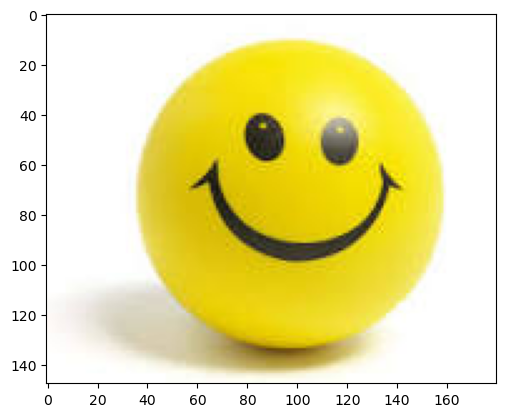

In [4]:
img2=cv2.imread('download.jpg')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

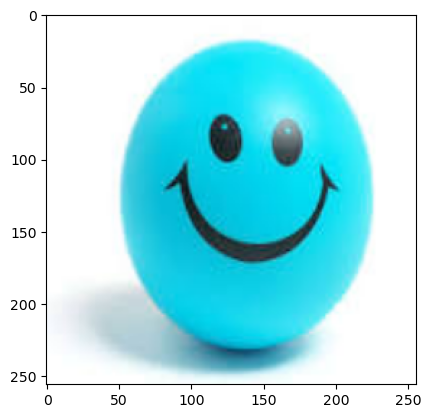

In [5]:
resize = tf.image.resize(img2, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [6]:
resize

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 25

In [7]:
import numpy as np

In [8]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 2s 2s/step


In [9]:
yhat

array([[0.30574483]], dtype=float32)

Predicted class is Happy


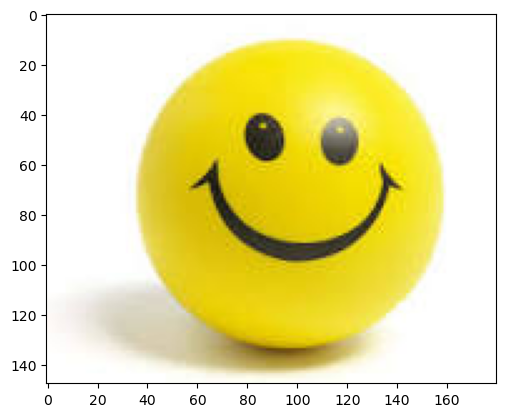

In [10]:
if yhat>0.5:
    print(f'Predicted class is Sad')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print(f'Predicted class is Happy')
    img2=cv2.imread('download.jpg')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.show()

### Successfully predicted happy or sad class